## Problem Statement :
## Use decision trees to prepare a model on fraud data 
**Treating those who have taxable_income <= 30000 as "Risky" and others are "Good"**

**Data Description :**

* **Undergrad :** person is under graduated or not
* **Marital.Status :** marital status of a person
* **Taxable.Income :** Taxable income is the amount of how much tax an individual owes to the government 
* **Work Experience :** Work experience of an individual person
* **Urban :** Whether that person belongs to urban area or not

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

## 2. Importing Dataset

In [2]:
fraud_check = pd.read_csv('D:\Assignment ExcelR\Decision Trees\Fraud_check.csv')
fraud_check

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


## 3. Data Exploration

In [3]:
fraud_check.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [4]:
fraud_check.shape

(600, 6)

In [5]:
fraud_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [6]:
fraud_check[fraud_check.duplicated()].shape

(0, 6)

In [7]:
fraud_check.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


### Feature Engineering
#### Converting taxable_income <= 30000 as "Risky" and others are "Good"

In [8]:
fraud_check1 = fraud_check.copy()
fraud_check1['Taxable.Category'] = pd.cut(x = fraud_check1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
fraud_check1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Taxable.Category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [9]:
fraud_check.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [10]:
categorical_features = fraud_check.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [11]:
numerical_features = fraud_check.describe(include=["int64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

## 4. Exploratory Data Analysis

### Univariate plots

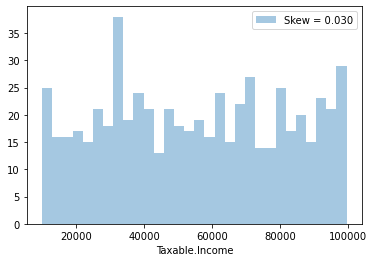

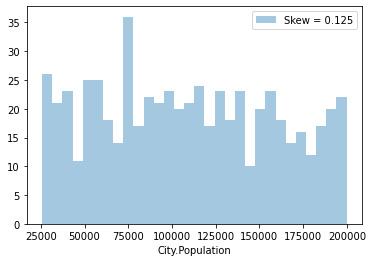

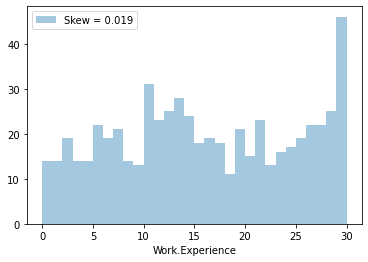

In [12]:
numerical_features = [feature for feature in fraud_check.columns if fraud_check[feature].dtypes != 'O']
for feat in numerical_features:
    skew = fraud_check[feat].skew()
    sns.distplot(fraud_check[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

#### Observation
* None of the features is normally distributed.

### Outliers

In [13]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

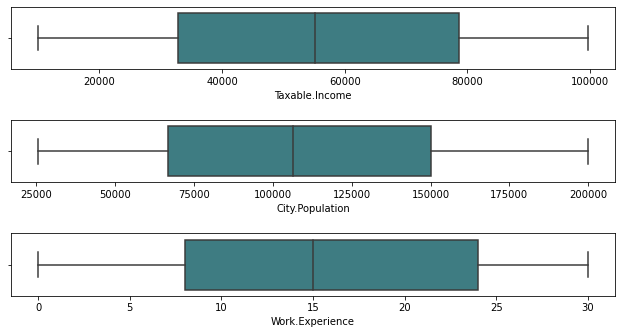

In [14]:
outlier = fraud_check.copy() 
fig, axes = plt.subplots(3,1,figsize=(9,5),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data= outlier,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data= outlier,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data= outlier,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

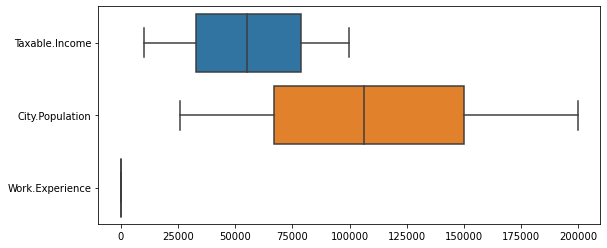

In [15]:
plt.figure(figsize=(9,4))
sns.boxplot(data= fraud_check[numerical_features], orient="h")
plt.show()

#### Observation:
* Work Experience has a mean that is much inferior to the other constituents as we already saw in the previous section.

### Multivariate Analysis
* Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

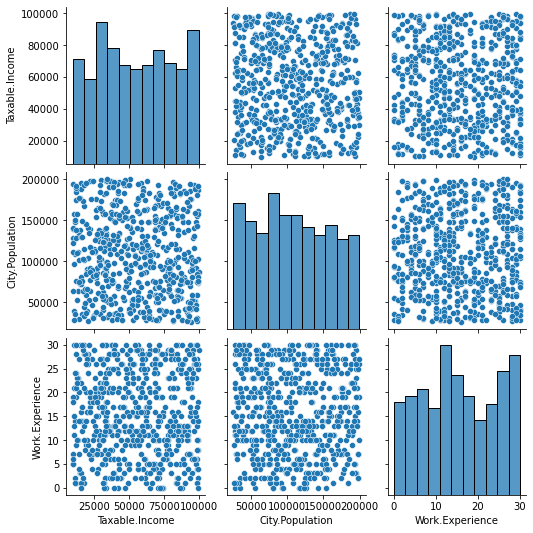

In [16]:
sns.pairplot(fraud_check, palette='coolwarm')
plt.show()

#### Having a look at the correlation matrix

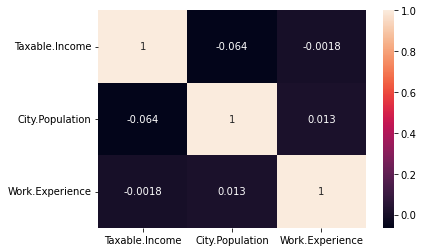

In [17]:
sns.heatmap(fraud_check.corr(), annot=True)
plt.show()

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


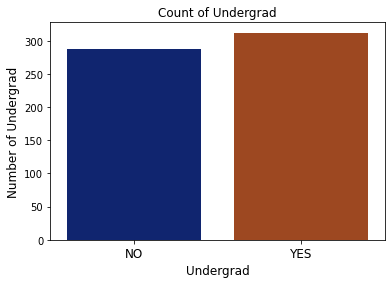

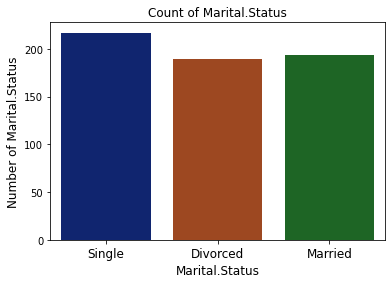

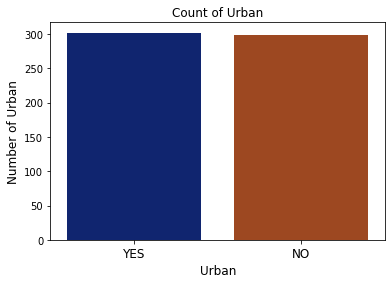

In [18]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(6,4))
    unique = fraud_check[column].value_counts(ascending=True);
   
    plt.title("Count of "+ column)
    sns.countplot(data= fraud_check, x=column,palette = "dark")
    plt.xticks(rotation = 0, size = 12)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

In [19]:
def factorplot(param):
    sns.factorplot(x = param, size = 5, aspect = 2, data = fraud_check, y= "Taxable.Income", palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Sales\n")
    plt.show()

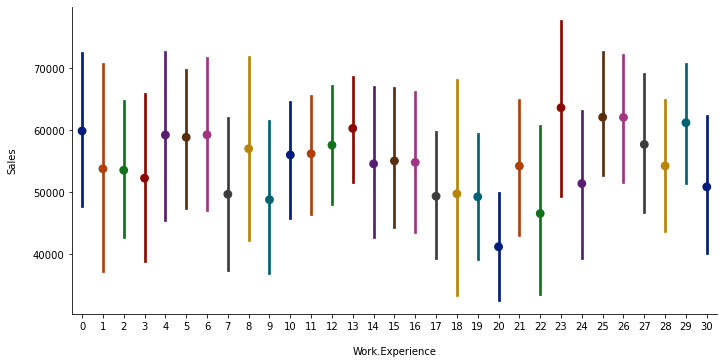

In [20]:
factorplot("Work.Experience")

#### Let's plot pair plot to visualise the attributes all at once

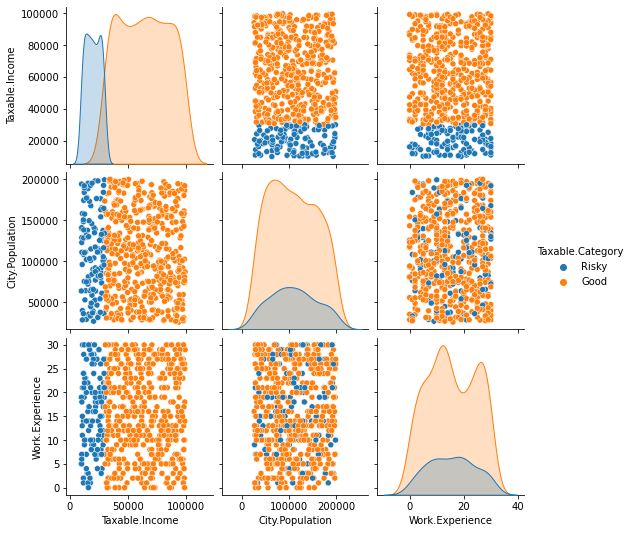

In [21]:
sns.pairplot(data= fraud_check1, hue = 'Taxable.Category')
plt.show()

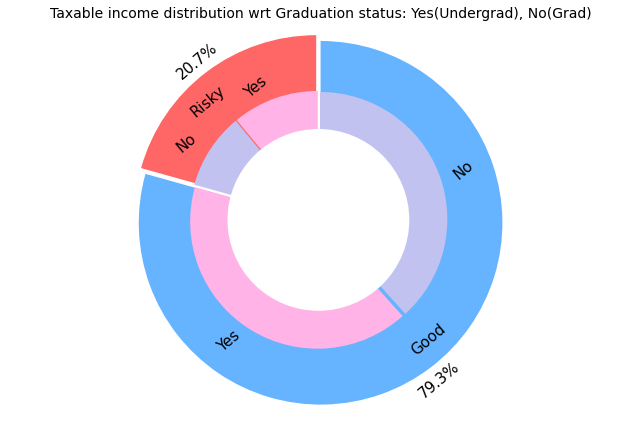

In [22]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1.Undergrad).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':'40'}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt Graduation status: Yes(Undergrad), No(Grad)', fontsize= 14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

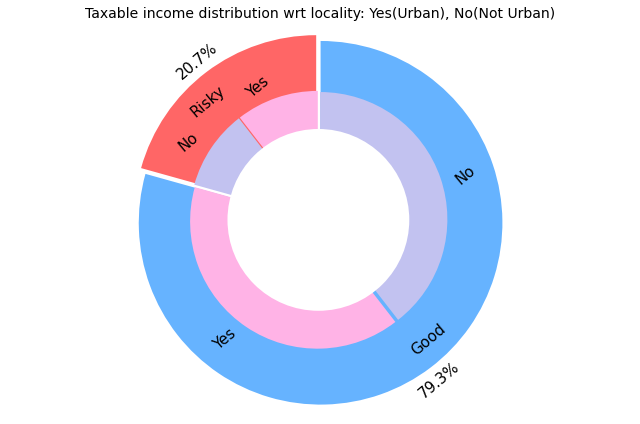

In [23]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1["Urban"]).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1["Urban"]).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':'40'}
#Plot
plt.pie(values, labels=labels, autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt locality: Yes(Urban), No(Not Urban)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

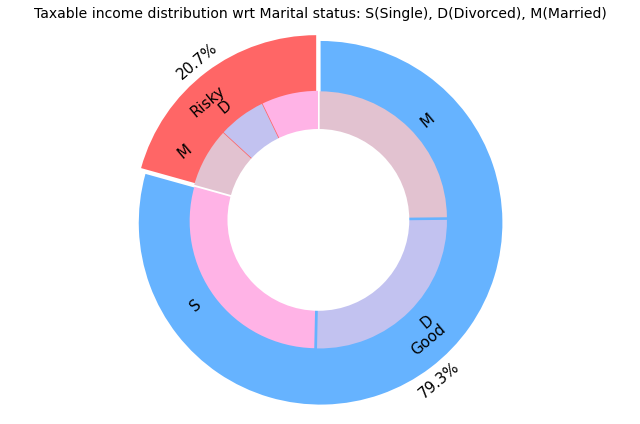

In [24]:
plt.figure(figsize=(9,6))
labels =["Risky", "Good"]
values = [fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Risky'].groupby(by = fraud_check1["Marital.Status"]).count().sum(),
         fraud_check1["Taxable.Category"][fraud_check1["Taxable.Category"] == 'Good'].groupby(by = fraud_check1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15, 'rotation':40}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution wrt Marital status: S(Single), D(Divorced), M(Married)', fontsize=14)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

### Checking for Imbalanced or balanced dataset with regards to the Target

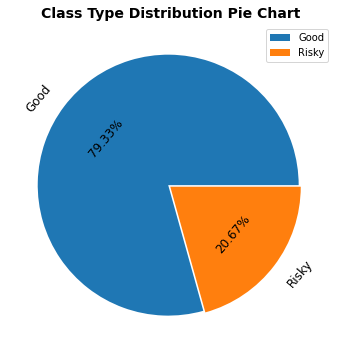

In [25]:
plt.figure(figsize = (9,6))
plt.pie(fraud_check1['Taxable.Category'].value_counts(),labels= fraud_check1['Taxable.Category'].unique(),
       explode = [0.02,0.0], autopct= '%.2f%%',textprops = {'size':'large','rotation':50,'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 14, fontweight = 'bold')
plt.show()

**Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations.**

Here, the class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [26]:
fraud_check1['Taxable.Category'].value_counts()

Good     476
Risky    124
Name: Taxable.Category, dtype: int64

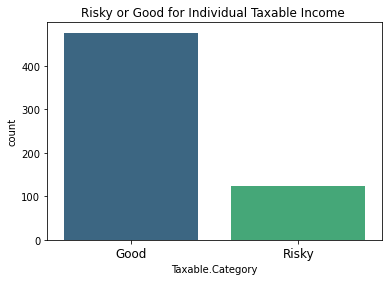

In [27]:
sns.countplot(x='Taxable.Category', data=fraud_check1, palette = 'viridis', order=fraud_check1['Taxable.Category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')
plt.show()

### Problems with imbalanced data classification

## 5. Data Pre-Processing

In [28]:
fraud_check1.columns

Index(['Undergrad', 'Marital.Status', 'Taxable.Income', 'City.Population',
       'Work.Experience', 'Urban', 'Taxable.Category'],
      dtype='object')

In [29]:
fraud_check2 = fraud_check1.copy()
fraud_check2.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','City.Population':'City_Population','Work.Experience':'Work_Experience','Taxable.Category':'Taxable_Category'}, inplace = True)
fraud_check2.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = fraud_check2.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'Taxable_Category'], dtype='object')

### Lable Encoding

#### Creating dummy vairables of the categorical features

In [30]:
fraud_check2.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'Taxable_Category'],
      dtype='object')

In [31]:
le = LabelEncoder()
for col in categorical_features:
        le.fit(fraud_check2[col])
        fraud_check2[col] = le.transform(fraud_check2[col])
fraud_check2.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,Taxable_Category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


In [32]:
fraud_check2.Taxable_Category.value_counts()

0    476
1    124
Name: Taxable_Category, dtype: int64

## 6. Model Building

### StratifiedKFold

In [33]:
x = fraud_check2.drop('Taxable_Category',axis=1)
y = fraud_check2[['Taxable_Category']]

In [34]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_x, test_x = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
    train, train1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test, test1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train, train1, test, test1))

>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60
>Train: 0=540, 1=540, Test: 0=60, 1=60


### Test Train Split With Imbalanced Dataset

In [35]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=0, stratify=y)

In [36]:
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=480, 1=480, Test: 0=120, 1=120


In [37]:
# summarize train and test composition
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({'Taxable_Category': 1}) Testing Data Counter({'Taxable_Category': 1})


In [38]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (480, 5)
Shape of x_test  :  (120, 5)
Shape of y_train :  (480, 1)
Shape of y_test  :  (120, 1)


## 7. Model Training And Testing

###  Grid Search using Stratified Kfold Splits on Imbalanced Dataset

In [39]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        pred = clf.predict(x_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n==========================================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("__________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("__________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(x_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n==========================================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("__________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("__________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [40]:
params = {"criterion":["gini", "entropy"], "splitter":["best", "random"], 
          "max_depth":[2,3,4,5,6,7,8], "min_samples_split":[2,3,4,5,6,7,8], "min_samples_leaf":[2,3,4,5,6,7,8]}

tree_clf = DecisionTreeClassifier(random_state=12)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(train_x, train_y)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(train_x, train_y)
print_score(tree_clf, train_x, train_y, test_x, test_y, train=True)
print_score(tree_clf, train_x, train_y, test_x, test_y, train=False)

Fitting 3 folds for each of 1372 candidates, totalling 4116 fits
Best paramters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'random'})
Train Result:
Accuracy Score: 80.00%
__________________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.801126    0.714286       0.8    0.757706      0.783275
recall       0.995338    0.045045       0.8    0.520192      0.800000
f1-score     0.887734    0.084746       0.8    0.486240      0.722675
support    429.000000  111.000000       0.8  540.000000    540.000000
__________________________________________________________________________
Confusion Matrix: 
 [[427   2]
 [106   5]]

Test Result:
Accuracy Score: 78.33%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision  

#### Get score for different values of n

In [41]:
decision_tree = DecisionTreeClassifier()
skf1 = StratifiedKFold(n_splits=15, shuffle=True, random_state=12)

results = cross_val_score(decision_tree, train_x, train_y, cv=skf1)
print(results.mean())

0.625925925925926


In [42]:
params1 = {"criterion":["gini","entropy"], "max_depth":[2,3,4,5,6,7,8],
              "min_samples_split":[2,3,4,5,6,7,8], "min_samples_leaf":[2,3,4,5,6,7,8]}

grid = GridSearchCV(decision_tree, param_grid = params1, cv=skf1, verbose=1, n_jobs=6)
grid.fit(train_x,train_y)
model1 = grid.best_estimator_

Fitting 15 folds for each of 686 candidates, totalling 10290 fits


In [43]:
grid.best_score_

0.7925925925925928

In [44]:
predict_output1 = model1.predict(test_x)
accuracy_test1 = accuracy_score(test_y,predict_output1)
accuracy_test1

0.7833333333333333

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       0.00      0.00      0.00        13

    accuracy                           0.78        60
   macro avg       0.39      0.50      0.44        60
weighted avg       0.61      0.78      0.69        60



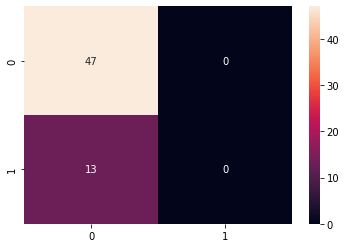

In [45]:
sns.heatmap(confusion_matrix(test_y, predict_output1), annot=True)
print(classification_report(test_y,predict_output1))

### Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [46]:
params = {"criterion":["gini", "entropy"], "splitter":["best", "random"], 
          "max_depth":[2,3,4,5,6,7,8], "min_samples_split":[2,3,4,5,6,7,8], "min_samples_leaf":[2,3,4,5,6,7,8]}

tree_clf = DecisionTreeClassifier(random_state=22)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 1372 candidates, totalling 4116 fits
Best paramters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'})
Train Result:
Accuracy Score: 79.38%
__________________________________________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.793750   0.0   0.79375    0.396875      0.630039
recall       1.000000   0.0   0.79375    0.500000      0.793750
f1-score     0.885017   0.0   0.79375    0.442509      0.702483
support    381.000000  99.0   0.79375  480.000000    480.000000
__________________________________________________________________________
Confusion Matrix: 
 [[381   0]
 [ 99   0]]

Test Result:
Accuracy Score: 79.17%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy   macro avg  weighted avg
precision   0.791667   0.0  0.791667    

#### Get score for different values of n

In [47]:
decision_tree = DecisionTreeClassifier()
skf2 = StratifiedKFold(n_splits=15, shuffle=True, random_state=14)

results = cross_val_score(decision_tree, x_train, y_train, cv=skf2)
print(results.mean())

0.6541666666666667


In [48]:
params2 = {"criterion":["gini","entropy"], "max_depth":[2,3,4,5,6,7,8],
              "min_samples_split":[2,3,4,5,6,7,8], "min_samples_leaf":[2,3,4,5,6,7,8]}

grid = GridSearchCV(decision_tree, param_grid = params2, cv=skf2, verbose=1, n_jobs=6)
grid.fit(x_train,y_train)
model2 = grid.best_estimator_

Fitting 15 folds for each of 686 candidates, totalling 10290 fits


In [49]:
grid.best_score_

0.7958333333333333

In [50]:
predict_output2 = model2.predict(x_test)
accuracy_test2 = accuracy_score(y_test,predict_output2)
accuracy_test2

0.7916666666666666

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        95
           1       0.00      0.00      0.00        25

    accuracy                           0.79       120
   macro avg       0.40      0.50      0.44       120
weighted avg       0.63      0.79      0.70       120



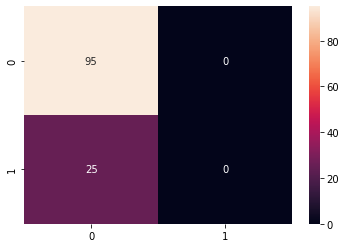

In [51]:
sns.heatmap(confusion_matrix(y_test, predict_output2),annot=True)
print(classification_report(y_test,predict_output2))

#### Observation:
* In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

## 8. Pruning

In [52]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        pred = clf.predict(x_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n==========================================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("__________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("__________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(x_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n==========================================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("__________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("__________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

params = {"criterion":["gini", "entropy"], "splitter":["best", "random"], "max_depth":[2,3,4,5,6,7,8], 
          "min_samples_split":[2,3,4,5,6,7,8], "min_samples_leaf":[2,3,4,5,6,7,8]}

tree_clf = DecisionTreeClassifier(random_state=123)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 10 folds for each of 1372 candidates, totalling 13720 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.79%
__________________________________________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.797071   1.000000  0.797917    0.898536      0.838925
recall       1.000000   0.020202  0.797917    0.510101      0.797917
f1-score     0.887078   0.039604  0.797917    0.463341      0.712286
support    381.000000  99.000000  0.797917  480.000000    480.000000
__________________________________________________________________________
Confusion Matrix: 
 [[381   0]
 [ 97   2]]

Test Result:
Accuracy Score: 79.17%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy   macro avg  weighted avg
precision   

#### This is a balanced state of training and testing accuracy are close to each other where there is no overfitting or underfitting yet we can do better than this, let's try post pruning technique using Alpha Values

In [53]:
clf = DecisionTreeClassifier(**best_params)
clf.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=2)

In [54]:
pred_train = clf.predict(x_train)
pred_test = clf.predict(x_test)

In [55]:
print('Training Accuracy :',accuracy_score(y_train, pred_train).round(3))
print('Testing Accuracy  :',accuracy_score(y_test, pred_test).round(3))

Training Accuracy : 0.798
Testing Accuracy  : 0.792


### Building Decision Tree Classifier using Entropy Criteria with Alpha values Post Pruning

In [56]:
model_entropy = DecisionTreeClassifier(criterion='entropy', random_state=10)
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

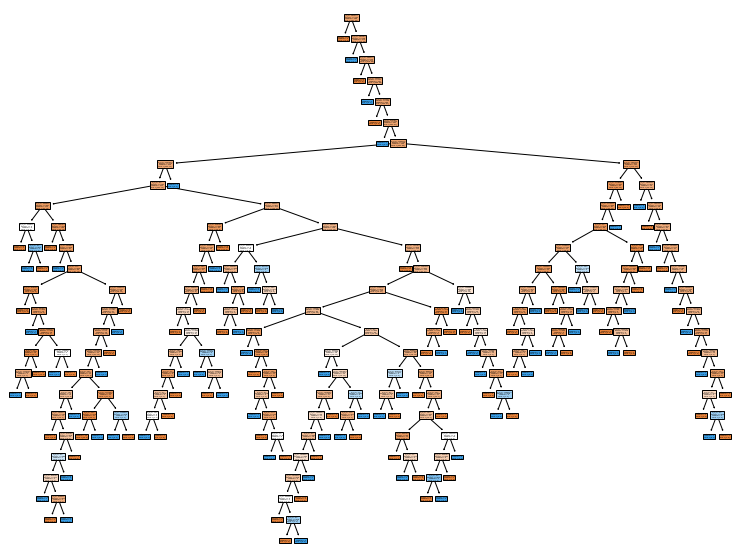

In [57]:
plt.figure(figsize=(13,10))
tree.plot_tree(model_entropy,filled=True)
plt.show()

#### Predicting on test data

In [58]:
preds = model_entropy.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

0    95
1    25
dtype: int64

#### Classification Report

In [59]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        95
           1       0.20      0.20      0.20        25

    accuracy                           0.67       120
   macro avg       0.49      0.49      0.49       120
weighted avg       0.67      0.67      0.67       120



In [60]:
path = model_entropy.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [61]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy',random_state=11, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.007057557152094937


#### Accuracy vs alpha for training and testing sets

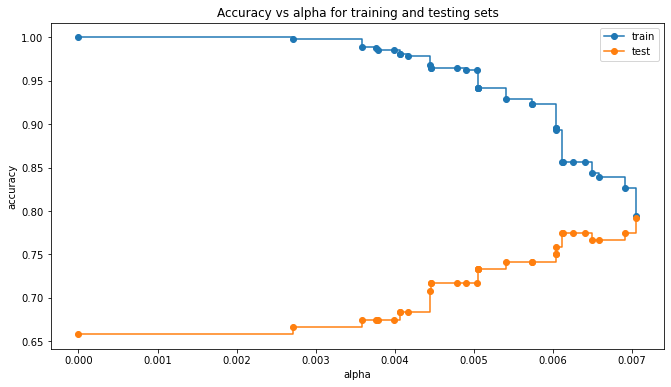

In [62]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(11,6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

### Choosing the best value of cc_alpha where the testing and training accuracy are almost same or near or closer to each other

In [63]:
clf1 = DecisionTreeClassifier(criterion='entropy',random_state=144, ccp_alpha=0.00705)
clf1.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00705, criterion='entropy', random_state=144)

In [64]:
pred_train1 = clf1.predict(x_train)
pred_test1 = clf1.predict(x_test)

print('Training Accuracy :',accuracy_score(y_train, pred_train1).round(3))
print('Testing Accuracy  :',accuracy_score(y_test, pred_test1).round(3))

Training Accuracy : 0.827
Testing Accuracy  : 0.775


              precision    recall  f1-score   support

           0       0.79      0.97      0.87        95
           1       0.25      0.04      0.07        25

    accuracy                           0.78       120
   macro avg       0.52      0.50      0.47       120
weighted avg       0.68      0.78      0.70       120



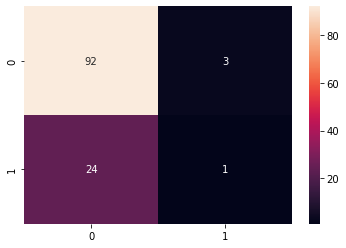

In [65]:
sns.heatmap(confusion_matrix(y_test, pred_test1),annot=True)
print(classification_report(y_test,pred_test1))

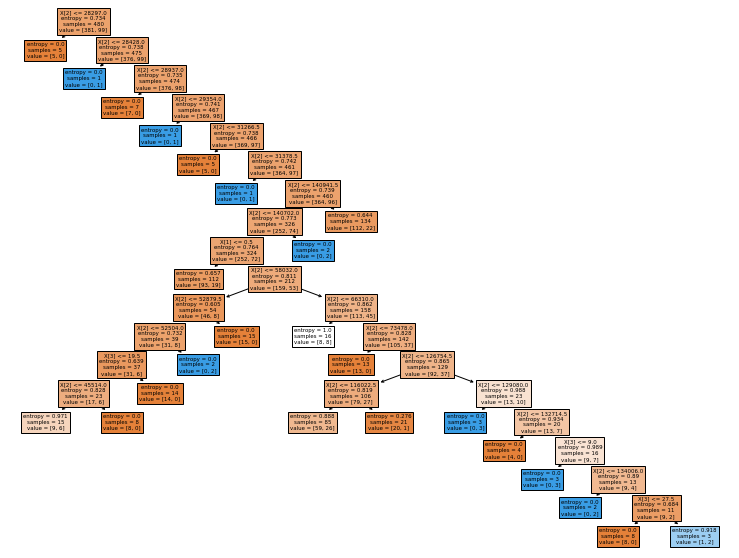

In [66]:
plt.figure(figsize=(13,10))
tree.plot_tree(clf1,filled=True)
plt.show()

### Building Decision Tree Classifier using Gini Criteria with Alpha values Post Pruning

In [67]:
model_gini = DecisionTreeClassifier(criterion='gini', random_state=10)
model_gini.fit(x_train,y_train)

DecisionTreeClassifier(random_state=10)

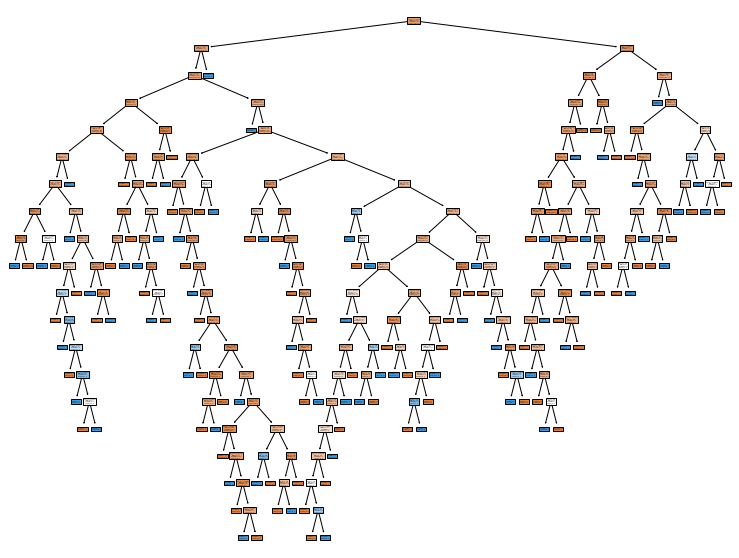

In [68]:
plt.figure(figsize=(13,10))
tree.plot_tree(model_gini,filled=True)
plt.show()

#### Predicting on test data

In [69]:
preds = model_gini.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

0    91
1    29
dtype: int64

#### Classification Report

In [70]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78        95
           1       0.24      0.28      0.26        25

    accuracy                           0.67       120
   macro avg       0.52      0.52      0.52       120
weighted avg       0.69      0.67      0.68       120



In [71]:
path = model_gini.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [72]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.004560921628414483


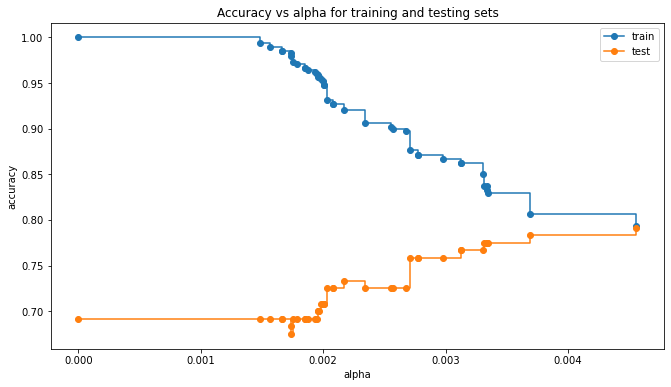

In [73]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(11,6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

### Choosing the best value of cc_alpha where the testing and training accuracy are almost same or near or closer to each other

In [74]:
clf2 = DecisionTreeClassifier(criterion='gini',random_state=145, ccp_alpha=0.00456)
clf2.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00456, random_state=145)

In [75]:
pred_train2 = clf2.predict(x_train)
pred_test2 = clf2.predict(x_test)

print('Training Accuracy :',accuracy_score(y_train, pred_train2).round(3))
print('Testing Accuracy  :',accuracy_score(y_test, pred_test2).round(3))

Training Accuracy : 0.806
Testing Accuracy  : 0.783


              precision    recall  f1-score   support

           0       0.79      0.99      0.88        95
           1       0.00      0.00      0.00        25

    accuracy                           0.78       120
   macro avg       0.39      0.49      0.44       120
weighted avg       0.63      0.78      0.70       120



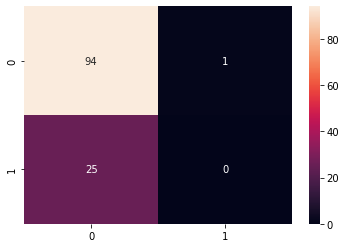

In [76]:
sns.heatmap(confusion_matrix(y_test, pred_test2),annot=True)
print(classification_report(y_test,pred_test2))

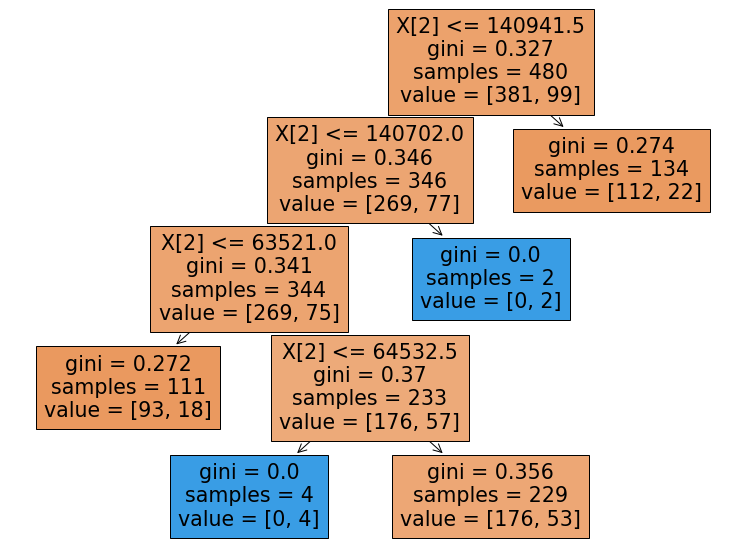

In [77]:
plt.figure(figsize=(13,10))
tree.plot_tree(clf2,filled=True)
plt.show()

## 9. Model Optimization

#### Using best paramters: 'criterion': 'entropy',  'max_depth': 3 (GridSearchCV)

In [78]:
print(f"Training Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}%")
print(f"Testing Accuracy : {accuracy_score(y_test, pred_test) * 100:.2f}%")

Training Accuracy: 79.79%
Testing Accuracy : 79.17%


#### Using Entropy Criteria with Alpha values

In [79]:
print(f"Training Accuracy: {accuracy_score(y_train, pred_train1) * 100:.2f}%")
print(f"Testing Accuracy : {accuracy_score(y_test, pred_test1) * 100:.2f}%")

Training Accuracy: 82.71%
Testing Accuracy : 77.50%


#### Using Gini Criteria with Alpha values

In [80]:
print(f"Training Accuracy: {accuracy_score(y_train, pred_train2) * 100:.2f}%")
print(f"Testing Accuracy : {accuracy_score(y_test, pred_test2) * 100:.2f}%")

Training Accuracy: 80.62%
Testing Accuracy : 78.33%


## 10. Model Deployement

In [81]:
from pickle import dump

In [82]:
dump(tree_clf,open('fraud_check_intell.pkl','wb'))

# The End !!!